# Data Preparation

Here in this data preparation jupyter notebook, we will prepare our data that will go into a Convolutional Neural Network model later.

## 0. Setup parameters and load libraries

In [1]:
import glob
import hashlib
import io
import json
import os
import shutil
import sys
import tarfile
import urllib
import yaml
import zipfile

import geopandas as gpd
import pygmt as gmt
import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyproj
import quilt
import rasterio
import rasterio.mask
import rasterio.plot
import shapely.geometry
import skimage.util.shape
import tqdm
import xarray as xr

print("Python       :", sys.version.split("\n")[0])
print("Geopandas    :", gpd.__version__)
print("GMT          :", gmt.__version__)
print("Numpy        :", np.__version__)
print("Rasterio     :", rasterio.__version__)
print("Scikit-image :", skimage.__version__)
print("Xarray       :", xr.__version__)

Python       : 3.6.6 | packaged by conda-forge | (default, Oct 11 2018, 14:33:06) 
Geopandas    : 0.4.1
GMT          : 0.0.1a0+31.g97c2b4a
Numpy        : 1.16.2
Rasterio     : 1.0.13
Scikit-image : 0.14.2
Xarray       : 0.12.1


## 1. Get Data!

In [2]:
def download_to_path(path: str, url: str):
    r"""
    Download from a HTTP or FTP url to a filepath.

    >>> d = download_to_path(
    ...    path="highres/Data_20171204_02.csv",
    ...    url="ftp://data.cresis.ku.edu/data/rds/2017_Antarctica_Basler/csv_good/Data_20171204_02.csv",
    ... )
    >>> open("highres/Data_20171204_02.csv").readlines()
    ['LAT,LON,UTCTIMESOD,THICK,ELEVATION,FRAME,SURFACE,BOTTOM,QUALITY\n']
    >>> os.remove(path="highres/Data_20171204_02.csv")
    """

    folder, filename = os.path.split(p=path)
    downloaded_filename = os.path.basename(urllib.parse.urlparse(url=url).path)

    # Download file using URL first
    if not os.path.exists(os.path.join(folder, downloaded_filename)):
        r = urllib.request.urlretrieve(
            url=url, filename=os.path.join(folder, downloaded_filename)
        )

    # If downloaded file is not the final file (e.g. file is in an archive),
    # then extract the file from the archive!
    if filename != downloaded_filename:
        # Extract tar.gz archive file
        if downloaded_filename.endswith(("tgz", "tar.gz")):
            try:
                archive = tarfile.open(name=f"{folder}/{downloaded_filename}")
                archive.extract(member=filename, path=folder)
            except:
                raise
        # Extract from .zip archive file
        elif downloaded_filename.endswith((".zip")):
            try:
                archive = zipfile.ZipFile(file=f"{folder}/{downloaded_filename}")
                archive.extract(member=filename, path=folder)
            except:
                raise
        else:
            raise ValueError(
                f"Unsupported archive format for downloaded file: {downloaded_filename}"
            )

    return os.path.exists(path=path)

In [3]:
def check_sha256(path: str):
    """
    Returns SHA256 checksum of a file

    >>> d = download_to_path(
    ...    path="highres/Data_20171204_02.csv",
    ...    url="https://data.cresis.ku.edu/data/rds/2017_Antarctica_Basler/csv_good/Data_20171204_02.csv",
    ... )
    >>> check_sha256("highres/Data_20171204_02.csv")
    '53cef7a0d28ff92b30367514f27e888efbc32b1bda929981b371d2e00d4c671b'
    >>> os.remove(path="highres/Data_20171204_02.csv")
    """
    with open(file=path, mode="rb") as afile:
        sha = hashlib.sha256(afile.read())

    return sha.hexdigest()

## Parse [data_list.yml](/data_list.yml)

In [4]:
def parse_datalist(
    yaml_file: str = "data_list.yml",
    record_path: str = "files",
    schema: list = [
        "citekey",
        "folder",
        "location",
        "resolution",
        ["doi", "dataset"],
        ["doi", "literature"],
    ],
) -> pd.DataFrame:

    assert yaml_file.endswith((".yml", ".yaml"))

    with open(file=yaml_file, mode="r") as yml:
        y = yaml.safe_load(stream=yml)

    datalist = pd.io.json.json_normalize(
        data=y, record_path=record_path, meta=schema, sep="_"
    )

    return datalist

In [5]:
# Pretty print table with nice column order and clickable url links
pprint_table = lambda df, folder: IPython.display.HTML(
    df.query(expr="folder == @folder")
    .reindex(columns=["folder", "filename", "url", "sha256"])
    .style.format({"url": lambda url: f'<a target="_blank" href="{url}">{url}</a>'})
    .render(uuid=f"{folder}")
)
dataframe = parse_datalist()

In [6]:
# Code to autogenerate README.md files in highres/lowres/misc folders from data_list.yml
columns = ["Filename", "Location", "Resolution", "Literature Citation", "Data Citation"]
for folder, md_header in [
    ("lowres", "Low Resolution"),
    ("highres", "High Resolution"),
    ("misc", "Miscellaneous"),
]:
    assert folder in pd.unique(dataframe["folder"])
    md_name = f"{folder}/README.md"

    with open(file=md_name, mode="w") as md_file:
        md_file.write(f"# {md_header} Antarctic datasets\n\n")
        md_file.write("Note: This file was automatically generated from ")
        md_file.write("[data_list.yml](/data_list.yml) using ")
        md_file.write("[data_prep.ipynb](/data_prep.ipynb)\n\n")

    md_table = pd.DataFrame(columns=columns)
    md_table.loc[0] = ["---", "---", "---", "---", "---"]

    keydf = dataframe.groupby("citekey").aggregate(lambda x: set(x).pop())
    for row in keydf.query(expr="folder == @folder").itertuples():
        filecount = len(dataframe[dataframe["citekey"] == row.Index])
        extension = os.path.splitext(row.filename)[-1]
        row_dict = {
            "Filename": row.filename
            if filecount == 1
            else f"{filecount} *{extension} files",
            "Location": row.location,
            "Resolution": row.resolution,
            "Literature Citation": f"[{row.Index}]({row.doi_literature})",
            "Data Citation": f"[DOI]({row.doi_dataset})"
            if row.doi_dataset != "nan"
            else None,
        }
        md_table = md_table.append(other=row_dict, ignore_index=True)

    md_table.to_csv(path_or_buf=md_name, mode="a", sep="|", index=False)

### Download Low Resolution bed elevation data (e.g. [BEDMAP2](https://doi.org/10.5194/tc-7-375-2013))

In [7]:
for dataset in dataframe.query(expr="folder == 'lowres'").itertuples():
    path = f"{dataset.folder}/{dataset.filename}"  # path to download the file to
    if not os.path.exists(path=path):
        download_to_path(path=path, url=dataset.url)
    assert check_sha256(path=path) == dataset.sha256
pprint_table(dataframe, "lowres")

,folder,filename,url,sha256
0,lowres,bedmap2_bed.tif,http://data.pgc.umn.edu/elev/dem/bedmap2/bedmap2_bed.tif,28e2ca7656d61b0bc7f8f8c1db41914023e0cab1634e0ee645f38a87d894b416


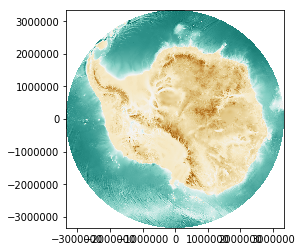

In [8]:
with rasterio.open("lowres/bedmap2_bed.tif") as raster_source:
    rasterio.plot.show(source=raster_source, cmap="BrBG_r")

### Download miscellaneous data (e.g. [REMA](https://doi.org/10.7910/DVN/SAIK8B), [MEaSUREs Ice Flow](https://doi.org/10.5067/D7GK8F5J8M8R), [LISA](https://doi.org/10.7265/nxpc-e997), [Arthern Accumulation](https://doi.org/10.1029/2004JD005667))

In [9]:
for dataset in dataframe.query(expr="folder == 'misc'").itertuples():
    path = f"{dataset.folder}/{dataset.filename}"  # path to download the file to
    if not os.path.exists(path=path):
        download_to_path(path=path, url=dataset.url)
    assert check_sha256(path=path) == dataset.sha256
pprint_table(dataframe, "misc")

,folder,filename,url,sha256
1,misc,REMA_100m_dem.tif,http://data.pgc.umn.edu/elev/dem/setsm/REMA/mosaic/v1.1/100m/REMA_100m_dem.tif,80c9fa41ccc69be1d2cd4a367d56168321d1079e7260a1996089810db25172f6
2,misc,REMA_200m_dem_filled.tif,http://data.pgc.umn.edu/elev/dem/setsm/REMA/mosaic/v1.1/200m/REMA_200m_dem_filled.tif,f750893861a1a268c8ffe0ba7db36c933223bbf5fcbb786ecef3f052b20f9b8a
3,misc,MEaSUREs_IceFlowSpeed_450m.tif,http://data.pgc.umn.edu/gis/packages/quantarctica/Quantarctica3/Glaciology/MEaSUREs%20Ice%20Flow%20Velocity/MEaSUREs_IceFlowSpeed_450m.tif,4a4efc3a84204c3d67887e8d7fa1186467b51e696451f2832ebbea3ca491c8a8
28,misc,lisa750_2013182_2017120_0000_0400_vv_v1.tif,ftp://ftp.nsidc.org/pub/DATASETS/nsidc0733_landsat_ice_speed_v01/LISA750/lisa750_2013182_2017120_0000_0400_v1.tgz,99eb934702305e2d27afa20dfc211c1d45ed762727bda29e0f251976a1877a92
29,misc,Arthern_accumulation_bedmap2_grid1.tif,https://secure.antarctica.ac.uk/data/bedmap2/resources/Arthern_accumulation/Arthern_accumulation_tif.zip,e6b139801bf4541f1e4989a8aa8b26ab37eca81bb5eaffa8028b744782455db0
30,misc,GroundingLine_Antarctica_v2.shp,http://data.pgc.umn.edu/gis/packages/quantarctica/Quantarctica3/Glaciology/MEaSUREs%20Antarctic%20Boundaries/GroundingLine_Antarctica_v2.shp,2d8f84e301c4e33ad1cb480aa260b8208b3fcaa00df0b68593ffe7d5aa6c9d7e
31,misc,GroundingLine_Antarctica_v2.shx,http://data.pgc.umn.edu/gis/packages/quantarctica/Quantarctica3/Glaciology/MEaSUREs%20Antarctic%20Boundaries/GroundingLine_Antarctica_v2.shx,01eaff4a35b4cd840a3fb1bdb63f7e51b2792c2ccd92d4621cb5d97cb3e365bc
32,misc,GroundingLine_Antarctica_v2.dbf,http://data.pgc.umn.edu/gis/packages/quantarctica/Quantarctica3/Glaciology/MEaSUREs%20Antarctic%20Boundaries/GroundingLine_Antarctica_v2.dbf,1cfbe90b262a7fb81cbe61af4f75b23e03213a078ed866e66c6467ab422e017e


### Download High Resolution bed elevation data (e.g. some-DEM-name)

In [10]:
for dataset in dataframe.query(expr="folder == 'highres'").itertuples():
    path = f"{dataset.folder}/{dataset.filename}"  # path to download the file to
    if not os.path.exists(path=path):
        download_to_path(path=path, url=dataset.url)
    assert check_sha256(path=path) == dataset.sha256
pprint_table(dataframe, "highres")

,folder,filename,url,sha256
4,highres,bed_WGS84_grid.txt,http://ramadda.nerc-bas.ac.uk/repository/entry/get/Polar%20Data%20Centre/DOI/Rutford%20Ice%20Stream%20bed%20elevation%20DEM%20from%20radar%20data/bed_WGS84_grid.txt?entryid=synth%3A54757cbe-0b13-4385-8b31-4dfaa1dab55e%3AL2JlZF9XR1M4NF9ncmlkLnR4dA%3D%3D,7396e56cda5adb82cecb01f0b3e01294ed0aa6489a9629f3f7e8858ea6cb91cf
5,highres,2007t1.txt,nan,04bdbd3c8e814cbc8f0d324277e339a46cc90a8dc23434d11815a8966951e766
6,highres,2007tr.txt,nan,3858a1e58e17b2816920e1b309534cee0391f72a6a0aa68d57777b030e70e9a3
7,highres,2010tr.txt,nan,751ea56acc5271b3fb54893ed59e05ff485187a6fc5daaedf75946d730805b80
8,highres,istar08.txt,nan,ed03c64332e8d406371c74a66f3cd21fb3f78ee498ae8408c355879bb89eb13d
9,highres,istar18.txt,nan,3e69d86f28e26810d29b0b9309090684dcb295c0dd39007fe9ee0d1285c57804
10,highres,istar15.txt,nan,59c981e8c96f73f3a5bd98be6570e101848b4f67a12d98a577292e7bcf776b17
11,highres,istar13.txt,nan,f5bcf80c7ea5095e2eabf72b69a264bf36ed56af5cb67976f9428f560e5702a2
12,highres,istar17.txt,nan,f51a674dc27d6e0b99d199949a706ecf96ea807883c1901fea186efc799a36e8
13,highres,istar07.txt,nan,c81ec04290433f598ce4368e4aae088adeeabb546913edc44c54a5a5d7593e93


## 2. Process high resolution data into grid format

Our processing step involves two stages:

1) Cleaning up the raw **vector** data, performing necessary calculations and reprojections to EPSG:3031.

2) Convert the cleaned vector data table via an interpolation function to a **raster** grid.

### 2.1 [Raw ASCII Text](https://pdal.io/stages/readers.text.html) to [Clean XYZ table](https://gmt.soest.hawaii.edu/doc/latest/GMT_Docs.html#table-data)

![Raw ASCII to Clean Table via pipeline file](https://yuml.me/diagram/scruffy;dir:LR/class/[Raw-ASCII-Text|*.csv/*.txt]->[Pipeline-File|*.json],[Pipeline-File]->[Clean-XYZ-Table|*.xyz])

In [11]:
def ascii_to_xyz(pipeline_file: str) -> pd.DataFrame:
    """
    Converts ascii txt/csv files to xyz pandas.DataFrame via
    a JSON Pipeline file similar to the one used by PDAL.

    >>> os.makedirs(name="/tmp/highres", exist_ok=True)
    >>> d = download_to_path(
    ...    path="/tmp/highres/2011_Antarctica_TO.csv",
    ...    url="https://data.cresis.ku.edu/data/rds/2011_Antarctica_TO/csv_good/2011_Antarctica_TO.csv",
    ... )
    >>> _ = shutil.copy(src="highres/20xx_Antarctica_TO.json", dst="/tmp/highres")
    >>> df = ascii_to_xyz(pipeline_file="/tmp/highres/20xx_Antarctica_TO.json")
    >>> df.head(2)
                   x             y         z
    0  345580.826265 -1.156471e+06 -377.2340
    1  345593.322948 -1.156460e+06 -376.6332
    >>> shutil.rmtree(path="/tmp/highres")
    """
    assert os.path.exists(pipeline_file)
    assert pipeline_file.endswith((".json"))

    # Read json file first
    j = json.loads(open(pipeline_file).read())
    jdf = pd.io.json.json_normalize(j, record_path="pipeline")
    jdf = jdf.set_index(keys="type")
    reader = jdf.loc["readers.text"]  # check how to read the file(s)

    ## Basic table read
    skip = int(reader.skip)  # number of header rows to skip
    sep = reader.separator  # delimiter to use
    names = reader.header.split(sep=sep)  # header/column names as list
    usecols = reader.usecols.split(sep=sep)  # column names to use
    na_values = None if not hasattr(reader, "na_values") else reader.na_values

    path_pattern = os.path.join(os.path.dirname(pipeline_file), reader.filename)
    files = [file for file in glob.glob(path_pattern)]
    assert len(files) > 0  # check that there are actually files being matched!

    df = pd.concat(
        pd.read_csv(
            f, sep=sep, header=skip, names=names, usecols=usecols, na_values=na_values
        )
        for f in files
    )
    df.reset_index(drop=True, inplace=True)  # reset index after concatenation

    ## Advanced table read with conversions
    try:
        # Perform math operations
        newcol, expr = reader.converters.popitem()
        df[newcol] = df.eval(expr=expr)
        # Drop unneeded columns
        dropcols = reader.dropcols.split(sep=sep)
        df.drop(columns=dropcols, inplace=True)
    except AttributeError:
        pass

    assert len(df.columns) == 3  # check that we have 3 columns i.e. x, y, z
    df.sort_index(axis="columns", inplace=True)  # sort cols alphabetically
    df.set_axis(labels=["x", "y", "z"], axis="columns", inplace=True)  # lower case

    ## Reproject x and y coordinates if necessary
    try:
        reproject = jdf.loc["filters.reprojection"]
        p1 = pyproj.Proj(init=reproject.in_srs)
        p2 = pyproj.Proj(init=reproject.out_srs)
        reproj_func = lambda x, y: pyproj.transform(p1=p1, p2=p2, x=x, y=y)

        x2, y2 = reproj_func(np.array(df["x"]), np.array(df["y"]))
        df["x"] = pd.Series(x2)
        df["y"] = pd.Series(y2)

    except KeyError:
        pass

    return df

In [12]:
xyz_dict = {}
for pf in sorted(glob.glob("highres/*.json")):
    print(f"Processing {pf} pipeline", end=" ... ")
    name = os.path.splitext(os.path.basename(pf))[0]
    xyz_dict[name] = ascii_to_xyz(pipeline_file=pf)
    print(f"{len(xyz_dict[name])} datapoints")

Processing highres/2007tx.json pipeline ... 42995 datapoints
Processing highres/2010tr.json pipeline ... 84922 datapoints
Processing highres/201x_Antarctica_Basler.json pipeline ... 2325792 datapoints
Processing highres/20xx_Antarctica_DC8.json pipeline ... 12840213 datapoints
Processing highres/20xx_Antarctica_TO.json pipeline ... 2895926 datapoints
Processing highres/WISE_ISODYN_RadarByFlight.json pipeline ... 2700265 datapoints
Processing highres/bed_WGS84_grid.json pipeline ... 244279 datapoints
Processing highres/istarxx.json pipeline ... 396369 datapoints


### 2.2 [Clean XYZ table](https://gmt.soest.hawaii.edu/doc/latest/GMT_Docs.html#table-data) to [Raster Grid](https://gmt.soest.hawaii.edu/doc/latest/GMT_Docs.html#grid-files)

![Clean XYZ Table to Raster Grid via interpolation function](https://yuml.me/diagram/scruffy;dir:LR/class/[Clean-XYZ-Table|*.xyz]->[Interpolation-Function],[Interpolation-Function]->[Raster-Grid|*.tif/*.nc])

In [13]:
def get_region(xyz_data: pd.DataFrame) -> str:
    """
    Gets the bounding box region of an xyz pandas.DataFrame in string
    format xmin/xmax/ymin/ymax rounded to 5 decimal places.
    Used for the -R 'region of interest' parameter in GMT.

    >>> xyz_data = pd.DataFrame(np.random.RandomState(seed=42).rand(30).reshape(10, 3))
    >>> get_region(xyz_data=xyz_data)
    '0.05808/0.83244/0.02058/0.95071'
    """
    xmin, ymin, _ = xyz_data.min(axis="rows")
    xmax, ymax, _ = xyz_data.max(axis="rows")
    return f"{xmin:.5f}/{xmax:.5f}/{ymin:.5f}/{ymax:.5f}"

In [14]:
def xyz_to_grid(
    xyz_data: pd.DataFrame,
    region: str,
    spacing: int = 250,
    tension: float = 0.35,
    outfile: str = None,
    mask_cell_radius: int = 3,
):
    """
    Performs interpolation of x, y, z point data to a raster grid.

    >>> xyz_data = 1000*pd.DataFrame(np.random.RandomState(seed=42).rand(60).reshape(20, 3))
    >>> region = get_region(xyz_data=xyz_data)
    >>> grid = xyz_to_grid(xyz_data=xyz_data, region=region, spacing=250)
    >>> grid.to_array().shape
    (1, 5, 5)
    >>> grid.to_array().values
    array([[[403.17618 , 544.92535 , 670.7824  , 980.75055 , 961.47723 ],
            [379.0757  , 459.26407 , 314.38297 , 377.78555 , 546.0469  ],
            [450.67664 , 343.26    ,  88.391594, 260.10492 , 452.3337  ],
            [586.09906 , 469.74008 , 216.8168  , 486.9802  , 642.2116  ],
            [451.4794  , 652.7244  , 325.77896 , 879.8973  , 916.7921  ]]],
          dtype=float32)
    """
    ## Preprocessing with blockmedian
    with gmt.helpers.GMTTempFile(suffix=".txt") as tmpfile:
        with gmt.clib.Session() as lib:
            file_context = lib.virtualfile_from_matrix(matrix=xyz_data.values)
            with file_context as infile:
                kwargs = {"V": "", "R": region, "I": f"{spacing}+e"}
                arg_str = " ".join(
                    [infile, gmt.helpers.build_arg_string(kwargs), "->" + tmpfile.name]
                )
                lib.call_module(module="blockmedian", args=arg_str)
            x, y, z = np.loadtxt(fname=tmpfile.name, unpack=True)

    ## XYZ point data to NetCDF grid via GMT surface
    grid = gmt.surface(
        x=x,
        y=y,
        z=z,
        region=region,
        spacing=f"{spacing}+e",
        T=tension,
        V="",
        M=f"{mask_cell_radius}c",
    )

    ## Save grid to NetCDF with projection information
    if outfile is not None:
        grid.to_netcdf(path=outfile)  ##TODO add CRS!!

    return grid

In [15]:
grid_dict = {}
for name in xyz_dict.keys():
    print(f"Gridding {name}", end=" ... ")
    xyz_data = xyz_dict[name]
    region = get_region(xyz_data)
    grid_dict[name] = xyz_to_grid(
        xyz_data=xyz_data, region=region, outfile=f"highres/{name}.nc"
    )
    print(f"done! {grid_dict[name].to_array().shape}")

Gridding 2007tx ... done! (1, 266, 74)
Gridding 2010tr ... done! (1, 92, 115)
Gridding 201x_Antarctica_Basler ... done! (1, 9062, 7437)
Gridding 20xx_Antarctica_DC8 ... done! (1, 12388, 15326)
Gridding 20xx_Antarctica_TO ... done! (1, 7671, 12287)
Gridding WISE_ISODYN_RadarByFlight ... done! (1, 5320, 5292)
Gridding bed_WGS84_grid ... done! (1, 123, 163)
Gridding istarxx ... done! (1, 552, 377)


### 2.3 Plot raster grids

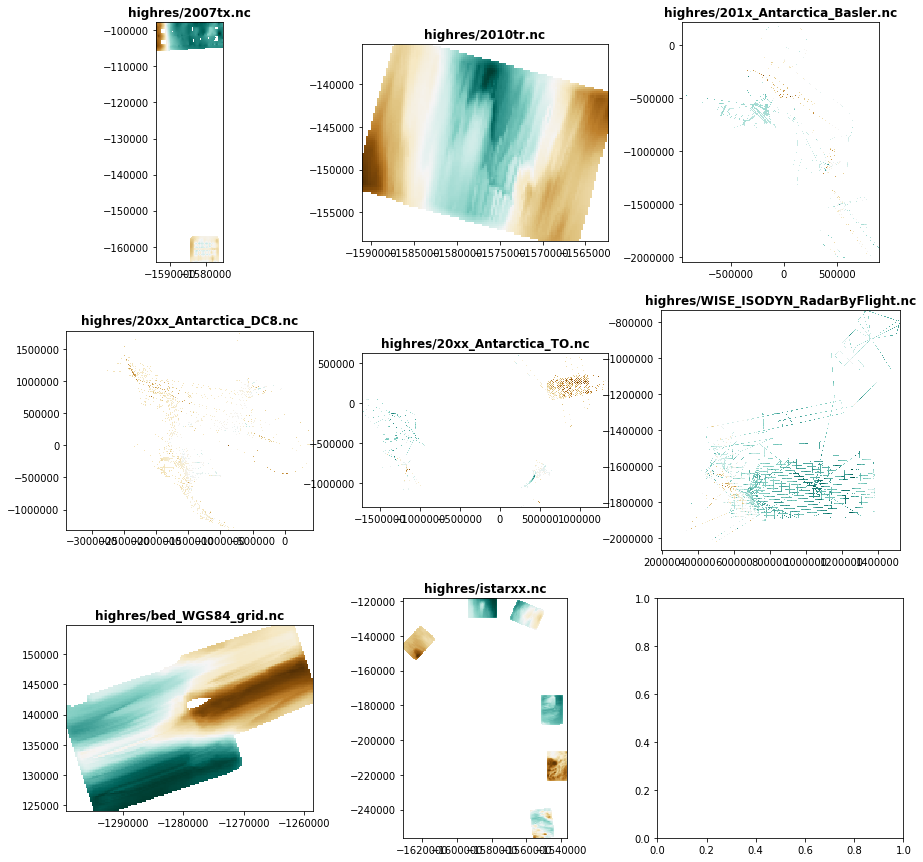

In [16]:
grids = sorted(glob.glob("highres/*.nc"))
fig, axarr = plt.subplots(
    nrows=1 + ((len(grids) - 1) // 3), ncols=3, squeeze=False, figsize=(15, 15)
)

for i, grid in enumerate(grids):
    with rasterio.open(grid) as raster_source:
        rasterio.plot.show(
            source=raster_source, cmap="BrBG_r", ax=axarr[i // 3, i % 3], title=grid
        )

## 3. Tile data

### Big raster to many small square tiles

In [17]:
def get_window_bounds(
    filepath: str, height: int = 32, width: int = 32, step: int = 4
) -> list:
    """
    Reads in a raster and finds tiles for them according to a stepped moving window.
    Returns a list of bounding box coordinates corresponding to a tile that looks like
    [(minx, miny, maxx, maxy), (minx, miny, maxx, maxy), ...]

    >>> xr.DataArray(
    ...     data=np.zeros(shape=(36, 32)),
    ...     coords={"x": np.arange(1, 37), "y": np.arange(1, 33)},
    ...     dims=["x", "y"],
    ... ).to_netcdf(path="/tmp/tmp_wb.nc")
    >>> get_window_bounds(filepath="/tmp/tmp_wb.nc")
    Tiling: /tmp/tmp_wb.nc ... 2
    [(0.5, 4.5, 32.5, 36.5), (0.5, 0.5, 32.5, 32.5)]
    >>> os.remove("/tmp/tmp_wb.nc")
    """
    assert height == width  # make sure it's a square!
    assert height % 2 == 0  # make sure we are passing in an even number

    with xr.open_rasterio(filepath) as dataset:
        print(f"Tiling: {filepath} ... ", end="")
        # Vectorized 'loop' along the raster image from top to bottom, and left to right

        # Get boolean true/false mask of where the data/nodata pixels lie
        mask = dataset.to_masked_array(copy=False).mask
        mask = mask[0, :, :]  # change to shape (height, width)

        # Sliding window view of the input geographical raster image
        window_views = skimage.util.shape.view_as_windows(
            arr_in=mask, window_shape=(height, width), step=step
        )
        filled_tiles = ~window_views.any(
            axis=(-2, -1)
        )  # find tiles which are fully filled, i.e. no blank/NODATA pixels
        tile_indexes = np.argwhere(filled_tiles)  # get x and y index of filled tiles

        # Convert x,y tile indexes to bounding box coordinates
        windows = [
            rasterio.windows.Window(
                col_off=ulx * step, row_off=uly * step, width=width, height=height
            )
            for uly, ulx in tile_indexes
        ]
        window_bounds = [
            rasterio.windows.bounds(
                window=window,
                transform=rasterio.Affine(*dataset.transform),
                width=width,
                height=height,
            )
            for window in windows
        ]
        print(len(window_bounds))

    return window_bounds

In [18]:
filepaths = sorted([g for g in glob.glob("highres/*.nc") if g != "highres/2007tx.nc"])
window_bounds = [get_window_bounds(filepath=grid) for grid in filepaths]
window_bounds_concat = np.concatenate([w for w in window_bounds]).tolist()
print(f"Total number of tiles: {len(window_bounds_concat)}")

Tiling: highres/2010tr.nc ... 164
Tiling: highres/201x_Antarctica_Basler.nc ... 961
Tiling: highres/20xx_Antarctica_DC8.nc ... 19
Tiling: highres/20xx_Antarctica_TO.nc ... 989
Tiling: highres/WISE_ISODYN_RadarByFlight.nc ... 19
Tiling: highres/bed_WGS84_grid.nc ... 172
Tiling: highres/istarxx.nc ... 175
Total number of tiles: 2499


### Show and save tiles

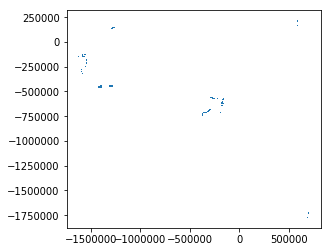

In [19]:
gdf = pd.concat(
    objs=[
        gpd.GeoDataFrame(
            pd.Series(
                data=len(window_bound) * [os.path.basename(filepath)], name="grid_name"
            ),
            crs={"init": "epsg:3031"},
            geometry=[shapely.geometry.box(*bound) for bound in window_bound],
        )
        for filepath, window_bound in zip(filepaths, window_bounds)
    ]
).reset_index(drop=True)
gdf.plot()

In [20]:
gdf.to_file(filename="model/train/tiles_3031.geojson", driver="GeoJSON")
gdf.to_crs(crs={"init": "epsg:4326"}).to_file(
    filename="model/train/tiles_4326.geojson", driver="GeoJSON"
)

### Do the actual tiling

In [21]:
def selective_tile(
    filepath: str,
    window_bounds: list,
    padding: int = 0,
    out_shape: tuple = None,
    gapfill_raster_filepath: str = None,
) -> np.ndarray:
    """
    Reads in raster and tiles them selectively.
    Tiles will go according to list of window_bounds.
    Output shape can be set to e.g. (16,16) to resample input raster to
    some desired shape/resolution.

    >>> xr.DataArray(
    ...     data=np.random.RandomState(seed=42).rand(64).reshape(8, 8),
    ...     coords={"x": np.arange(8), "y": np.arange(8)},
    ...     dims=["x", "y"],
    ... ).to_netcdf(path="/tmp/tmp_st.nc", mode="w")
    >>> selective_tile(
    ...    filepath="/tmp/tmp_st.nc",
    ...    window_bounds=[(1.0, 4.0, 3.0, 6.0), (2.0, 5.0, 4.0, 7.0)],
    ... )
    Tiling: /tmp/tmp_st.nc ... done!
    array([[[[0.18485446, 0.96958464],
             [0.4951769 , 0.03438852]]],
    <BLANKLINE>
    <BLANKLINE>
           [[[0.04522729, 0.32533032],
             [0.96958464, 0.77513283]]]], dtype=float32)
    >>> os.remove("/tmp/tmp_st.nc")
    """
    array_list = []

    with rasterio.open(filepath) as dataset:
        print(f"Tiling: {filepath} ... ", end="")
        for window_bound in window_bounds:

            if padding > 0:
                window_bound = (
                    window_bound[0] - padding,  # minx
                    window_bound[1] - padding,  # miny
                    window_bound[2] + padding,  # maxx
                    window_bound[3] + padding,  # maxy
                )

            window = rasterio.windows.from_bounds(
                *window_bound, transform=dataset.transform, precision=None
            ).round_offsets()

            # Read the raster according to the crop window
            array = dataset.read(
                indexes=list(range(1, dataset.count + 1)),
                masked=True,
                window=window,
                out_shape=out_shape,
            )
            assert array.ndim == 3  # check that we have shape like (1, height, width)
            assert array.shape[0] == 1  # channel-first (assuming only 1 channel)

            try:
                assert not array.mask.any()  # check that there are no NAN values
            except AssertionError:
                # Replace pixels from another raster if available, else raise error
                if gapfill_raster_filepath is not None:
                    with rasterio.open(gapfill_raster_filepath) as dataset2:
                        window2 = rasterio.windows.from_bounds(
                            *window_bound, transform=dataset2.transform, precision=None
                        ).round_offsets()

                        array2 = dataset2.read(
                            indexes=list(range(1, dataset2.count + 1)),
                            masked=True,
                            window=window2,
                            out_shape=array.shape[1:],
                        )

                    np.copyto(
                        dst=array, src=array2, where=array.mask
                    )  # fill in gaps where mask is True

                    # assert not array.mask.any()  # ensure no NAN values after gapfill
                else:
                    plt.imshow(array.data[0, :, :])
                    plt.show()
                    print(
                        f"WARN: Tile has missing data, try passing in gapfill_raster_filepath"
                    )

            # assert array.shape[0] == array.shape[1]  # check that height==width
            array_list.append(array.data.astype(dtype=np.float32))
        print("done!")

    return np.stack(arrays=array_list)

In [22]:
geodataframe = gpd.read_file("model/train/tiles_3031.geojson")
filepaths = geodataframe.grid_name.unique()
window_bounds = [
    [geom.bounds for geom in geodataframe.query("grid_name == @filepath").geometry]
    for filepath in filepaths
]
window_bounds_concat = np.concatenate([w for w in window_bounds]).tolist()

### Tile High Resolution data

In [23]:
hireses = [
    selective_tile(filepath=f"highres/{f}", window_bounds=w)
    for f, w in zip(filepaths, window_bounds)
]
hires = np.concatenate(hireses)
print(hires.shape, hires.dtype)

Tiling: highres/2010tr.nc
Tiling: highres/201x_Antarctica_Basler.nc
Tiling: highres/20xx_Antarctica_DC8.nc
Tiling: highres/20xx_Antarctica_TO.nc
Tiling: highres/WISE_ISODYN_RadarByFlight.nc
Tiling: highres/bed_WGS84_grid.nc
Tiling: highres/istarxx.nc
(2499, 1, 32, 32) float32


### Tile low resolution data

In [24]:
lores = selective_tile(
    filepath="lowres/bedmap2_bed.tif", window_bounds=window_bounds_concat, padding=1000
)
print(lores.shape, lores.dtype)

Tiling: lowres/bedmap2_bed.tif
(2499, 1, 10, 10) float32


### Tile miscellaneous data

In [25]:
rema = selective_tile(
    filepath="misc/REMA_100m_dem.tif",
    window_bounds=window_bounds_concat,
    padding=1000,
    gapfill_raster_filepath="misc/REMA_200m_dem_filled.tif",
)
print(rema.shape, rema.dtype)

Tiling: misc/REMA_100m_dem.tif
(2499, 1, 100, 100) float32


In [26]:
## Custom processing for LISA to standardize units with MEASURES Ice Velocity
# Convert units from metres/day to metres/year by multiplying 1st band by 365.25
!rio calc "(* 365.25 (read 1))" misc/lisa750_2013182_2017120_0000_0400_vv_v1.tif misc/lisa750_2013182_2017120_0000_0400_vv_v1_myr.tif
# Set NODATA mask where pixels are 36159.75 = 99 * 365.25
!rio edit-info misc/lisa750_2013182_2017120_0000_0400_vv_v1_myr.tif --nodata 36159.75
!rio info misc/lisa750_2013182_2017120_0000_0400_vv_v1_myr.tif

{"bounds": [-3174450.0, -2816675.0, 2867550.0, 2406325.0], "colorinterp": ["gray"], "count": 1, "crs": "EPSG:3031", "descriptions": [null], "driver": "GTiff", "dtype": "float32", "height": 6964, "indexes": [1], "interleave": "band", "lnglat": [-143.20725403435895, -87.64224776983792], "mask_flags": [["nodata"]], "nodata": 36159.75, "res": [750.0, 750.0], "shape": [6964, 8056], "tiled": false, "transform": [750.0, 0.0, -3174450.0, 0.0, -750.0, 2406325.0, 0.0, 0.0, 1.0], "units": [null], "width": 8056}


In [27]:
measuresiceflow = selective_tile(
    filepath="misc/MEaSUREs_IceFlowSpeed_450m.tif",
    window_bounds=window_bounds_concat,
    padding=1000,
    out_shape=(20, 20),
    # gapfill_raster_filepath="misc/lisa750_2013182_2017120_0000_0400_vv_v1_myr.tif",
)
print(measuresiceflow.shape, measuresiceflow.dtype)

Tiling: misc/MEaSUREs_IceFlowSpeed_450m.tif ... done!
(2499, 1, 20, 20) float32


## 4. Save the arrays

We'll save the numpy arrays to the filesystem first.
We label inputs as X (low resolution bed DEMs) and W (miscellaneous).
Groundtruth high resolution bed DEMs are labelled as Y.

Also, we'll serve the data up on the web using:
- [Quilt](https://quiltdata.com/) - Python data versioning
- [Dat](https://datproject.org/) - Distributed data sharing (TODO)

In [27]:
os.makedirs(name="model/train", exist_ok=True)
np.save(file="model/train/W1_data.npy", arr=rema)
np.save(file="model/train/W2_data.npy", arr=measuresiceflow)
np.save(file="model/train/X_data.npy", arr=lores)
np.save(file="model/train/Y_data.npy", arr=hires)

### Quilt

Login -> Build -> Push

In [28]:
quilt.login()

Launching a web browser...
If that didn't work, please visit the following URL: https://pkg.quiltdata.com/login



Enter the code from the webpage:  eyJpZCI6ICIyOWI4YzUyNS1lZmM1LTQ5NTItOGQ4Yy03NzQyYTg1YmI1MmEiLCAiY29kZSI6ICI2NjkyMzQxMC03ZDk0LTRlZjQtYjQ2NS03MWRhZDU1NTkxYzMifQ==


In [29]:
# Tiled datasets for training neural network
quilt.build(package="weiji14/deepbedmap/model/train/W1_data", path=rema)
quilt.build(package="weiji14/deepbedmap/model/train/W2_data", path=measuresiceflow)
quilt.build(package="weiji14/deepbedmap/model/train/X_data", path=lores)
quilt.build(package="weiji14/deepbedmap/model/train/Y_data", path=hires)

# Original datasets for neural network predictions on bigger area
quilt.build(
    package="weiji14/deepbedmap/lowres/bedmap2_bed", path="lowres/bedmap2_bed.tif"
)
quilt.build(
    package="weiji14/deepbedmap/misc/REMA_100m_dem", path="misc/REMA_100m_dem.tif"
)
quilt.build(
    package="weiji14/deepbedmap/misc/REMA_200m_dem_filled",
    path="misc/REMA_200m_dem_filled.tif",
)
quilt.build(
    package="weiji14/deepbedmap/misc/MEaSUREs_IceFlowSpeed_450m",
    path="misc/MEaSUREs_IceFlowSpeed_450m.tif",
)

In [30]:
quilt.push(package="weiji14/deepbedmap", is_public=True)

Fetching upload URLs from the registry...


  0%|          | 0.00/6.48G [00:00<?, ?B/s]

Uploading 11 fragments (6481462251 bytes)...


 26%|██▌       | 1.69G/6.48G [00:01<1:29:17, 893kB/s]

Fragment 1f66fe557ce079c063597f0b04d15862f67af2c9dd4f286801851e0c71f0e869 already uploaded; skipping.
Fragment f750893861a1a268c8ffe0ba7db36c933223bbf5fcbb786ecef3f052b20f9b8a already uploaded; skipping.
Fragment f1f660d1287225c30b8b2cbf2a727283d807a1ee443153519cbf407a08937965 already uploaded; skipping.
Fragment 28e2ca7656d61b0bc7f8f8c1db41914023e0cab1634e0ee645f38a87d894b416 already uploaded; skipping.
Fragment 4a4efc3a84204c3d67887e8d7fa1186467b51e696451f2832ebbea3ca491c8a8 already uploaded; skipping.
Fragment ca9c41a8dd56097e40865d2e65c65d299c22fc17608ddb6c604c532a69936307 already uploaded; skipping.
Fragment 80c9fa41ccc69be1d2cd4a367d56168321d1079e7260a1996089810db25172f6 already uploaded; skipping.


100%|██████████| 6.48G/6.48G [00:10<00:00, 637MB/s] 


Uploading package metadata...
Updating the 'latest' tag...
Push complete. weiji14/deepbedmap is live:
https://quiltdata.com/package/weiji14/deepbedmap
